In [1]:
# ============================================================
# CELL 1: IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import cross_val_score

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"   • pandas: {pd.__version__}")
print(f"   • numpy: {np.__version__}")
print("   • scikit-learn available\n")


✅ Libraries imported successfully!
   • pandas: 2.2.3
   • numpy: 1.26.4
   • scikit-learn available



In [5]:
# ============================================================
# CELL 2: LOAD DATA
# ============================================================

print("📂 Loading datasets...")

# Load splits
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

print(f"✅ Train: {train_df.shape}")
print(f"✅ Val:   {val_df.shape}")
print(f"✅ Test:  {test_df.shape}")

# Load metadata
with open('data/metadata.json', 'r') as f:
    metadata = json.load(f)

print("\n📋 Metadata:")
print(f"   • Total samples: {metadata['total_samples']:,}")
print(f"   • Features: {metadata['num_features']}")
print(f"   • Classes: {metadata['num_classes']}")

# Feature names
feature_names = metadata['feature_names']
class_names = metadata['class_names']

print("\n✅ Data loaded successfully!\n")


📂 Loading datasets...
✅ Train: (1540, 12)
✅ Val:   (330, 12)
✅ Test:  (330, 12)

📋 Metadata:
   • Total samples: 2,200
   • Features: 11
   • Classes: 22

✅ Data loaded successfully!



In [7]:
# ============================================================
# CELL 3: LOAD ENCODER & PREPARE DATA
# ============================================================

print("🔧 Loading encoder and preparing data...")

# Load label encoder
import joblib
label_encoder = joblib.load('data/label_encoder.pkl')
print(f"✅ Label encoder loaded ({len(label_encoder.classes_)} classes)")

# Load datasets
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

# Feature names (11 features)
feature_names = [
    'soil_temperature', 'soil_moisture', 'conductivity', 'ph',
    'nitrogen', 'phosphorus', 'potassium', 'salt',
    'air_temperature', 'air_humidity', 'is_raining'
]

# Separate features and labels
X_train = train_df[feature_names].values
y_train = train_df['label'].values  # Already encoded (0-21)
y_train_crop = label_encoder.inverse_transform(y_train)  # Convert to crop names

X_val = val_df[feature_names].values
y_val = val_df['label'].values

X_test = test_df[feature_names].values
y_test = test_df['label'].values
y_test_crop = label_encoder.inverse_transform(y_test)

print(f"✅ X_train: {X_train.shape}")
print(f"✅ y_train: {y_train.shape}")

# Check for missing values
print("\n🔍 Missing values:")
print(f"   • X_train: {np.isnan(X_train).sum()}")
print(f"   • X_val:   {np.isnan(X_val).sum()}")
print(f"   • X_test:  {np.isnan(X_test).sum()}")

# Label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\n📊 Label distribution (train):")
print(f"   • Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.1f}")
print(f"   • Balanced: {'✅ Yes' if counts.max() - counts.min() <= 5 else '❌ No'}")

print("\n✅ Data preparation complete!\n")

🔧 Loading encoder and preparing data...
✅ Label encoder loaded (22 classes)
✅ X_train: (1540, 11)
✅ y_train: (1540,)

🔍 Missing values:
   • X_train: 0
   • X_val:   0
   • X_test:  0

📊 Label distribution (train):
   • Min: 70, Max: 70, Mean: 70.0
   • Balanced: ✅ Yes

✅ Data preparation complete!



In [8]:
# ============================================================
# CELL 4: MODEL 1 - CROP CLASSIFIER
# ============================================================

print("=" * 80)
print("🌾 TRAINING MODEL 1: CROP CLASSIFIER (22 classes)")
print("=" * 80)

# Create model
crop_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train
print("\n🚀 Training...")
crop_classifier.fit(X_train, y_train)
print("✅ Training complete!")

# Predictions
y_train_pred = crop_classifier.predict(X_train)
y_val_pred = crop_classifier.predict(X_val)
y_test_pred = crop_classifier.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 ACCURACY:")
print(f"   • Train: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   • Val:   {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   • Test:  {test_acc:.4f} ({test_acc*100:.2f}%)")

# Success check
if test_acc >= 0.85:
    print(f"\n✅ SUCCESS: Test accuracy {test_acc*100:.2f}% >= 85%")
else:
    print(f"\n⚠️  WARNING: Test accuracy {test_acc*100:.2f}% < 85%")

# Detailed metrics
print("\n📋 Detailed Metrics (Test set):")
print(f"   • Precision (macro): {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"   • Recall (macro):    {recall_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"   • F1-score (macro):  {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# Save model
Path('models').mkdir(exist_ok=True)
joblib.dump(crop_classifier, 'models/crop_classifier.pkl')
print("\n💾 Model saved: models/crop_classifier.pkl\n")


🌾 TRAINING MODEL 1: CROP CLASSIFIER (22 classes)

🚀 Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


✅ Training complete!


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished



📊 ACCURACY:
   • Train: 0.9987 (99.87%)
   • Val:   0.9727 (97.27%)
   • Test:  0.9758 (97.58%)

✅ SUCCESS: Test accuracy 97.58% >= 85%

📋 Detailed Metrics (Test set):
   • Precision (macro): 0.9770
   • Recall (macro):    0.9758
   • F1-score (macro):  0.9755

💾 Model saved: models/crop_classifier.pkl



📊 Analyzing feature importance...

🏆 Top 5 Important Features:
   1. air_humidity        : 0.2141
   2. potassium           : 0.1713
   3. phosphorus          : 0.1376
   4. nitrogen            : 0.0897
   5. air_temperature     : 0.0728


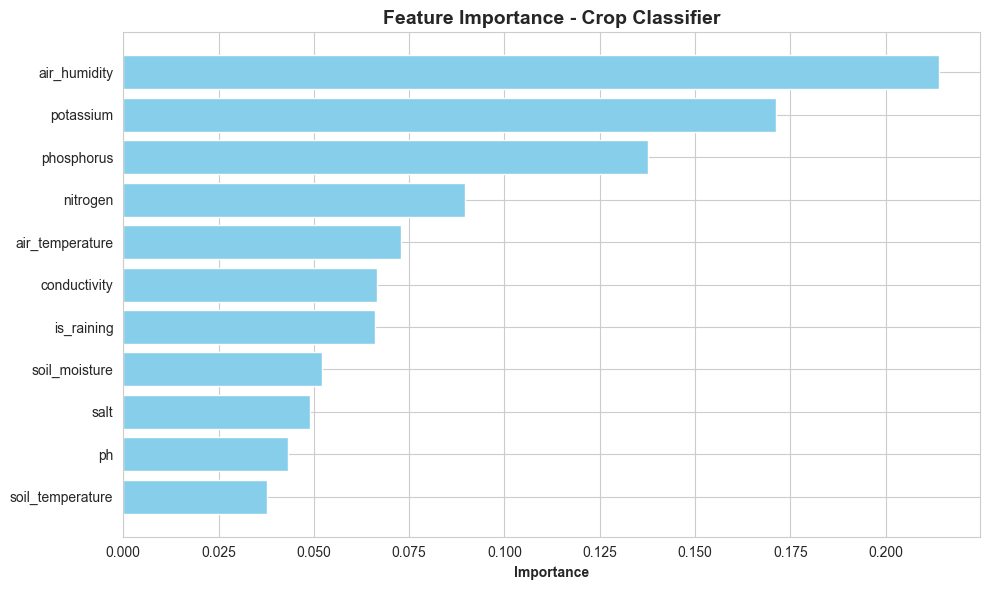


💾 Plot saved: models/feature_importance_crop_classifier.png


In [9]:
# ============================================================
# CELL 5: FEATURE IMPORTANCE
# ============================================================

print("📊 Analyzing feature importance...")

# Get feature importance
feature_importance = crop_classifier.feature_importances_
feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n🏆 Top 5 Important Features:")
for idx, (_, data) in enumerate(feature_imp_df.head(5).iterrows(), 1):
    print(f"   {idx}. {str(data['feature']).ljust(20)}: {data['importance']:.4f}")

# Ensure output dir exists (in case this cell runs standalone)
Path('models').mkdir(exist_ok=True)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['feature'], feature_imp_df['importance'], color='skyblue')
plt.xlabel('Importance', fontweight='bold')
plt.title('Feature Importance - Crop Classifier', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/feature_importance_crop_classifier.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved: models/feature_importance_crop_classifier.png")


🎯 Generating confusion matrix...


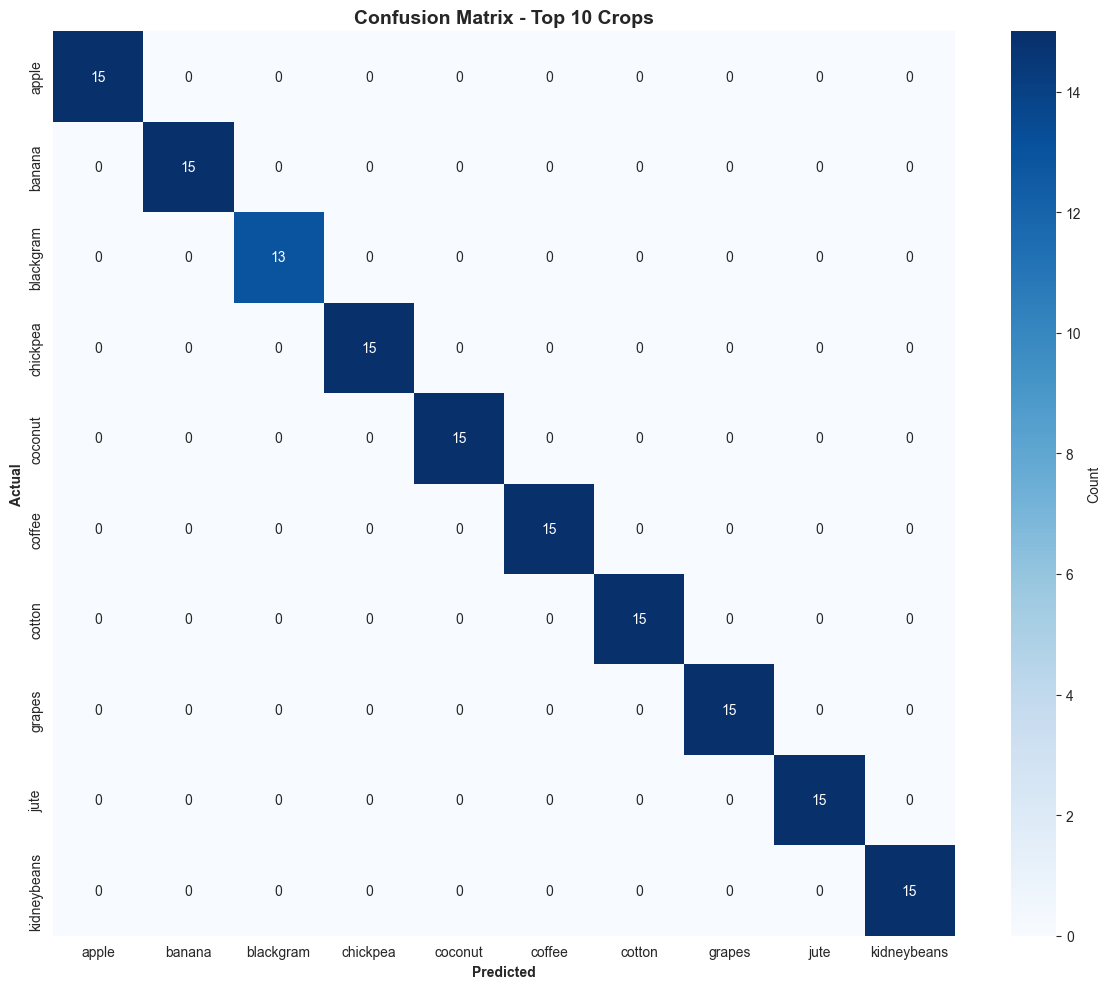


🏆 Best 3 Crops (highest accuracy):
   • watermelon: 100.00%
   • maize: 100.00%
   • banana: 100.00%

⚠️  Worst 3 Crops (lowest accuracy):
   • lentil: 66.67%
   • blackgram: 86.67%
   • rice: 93.33%

💾 Plot saved: models/confusion_matrix_crop_classifier.png


In [10]:
# ============================================================
# CELL 6: CONFUSION MATRIX
# ============================================================

print("🎯 Generating confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize (top 10 crops only for readability)
top_10_classes = list(range(min(10, len(class_names))))
cm_subset = cm[np.ix_(top_10_classes, top_10_classes)]
class_subset = [class_names[i] for i in top_10_classes]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_subset, yticklabels=class_subset,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix - Top 10 Crops', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('models/confusion_matrix_crop_classifier.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
best_3 = np.argsort(class_accuracy)[-3:][::-1]
worst_3 = np.argsort(class_accuracy)[:3]

print("\n🏆 Best 3 Crops (highest accuracy):")
for idx in best_3:
    print(f"   • {class_names[idx]}: {class_accuracy[idx]*100:.2f}%")

print("\n⚠️  Worst 3 Crops (lowest accuracy):")
for idx in worst_3:
    print(f"   • {class_names[idx]}: {class_accuracy[idx]*100:.2f}%")

print("\n💾 Plot saved: models/confusion_matrix_crop_classifier.png")


In [11]:
# ============================================================
# CELL 7: MODEL 2 - SOIL HEALTH SCORER
# ============================================================

print("=" * 80)
print("🌱 TRAINING MODEL 2: SOIL HEALTH SCORER (Regression)")
print("=" * 80)

# Generate synthetic soil health scores based on features
def calculate_soil_health_score(X, feature_names_list):
    """Calculate synthetic soil health score (0-100)"""
    scores = []
    
    # Get feature indices
    ph_idx = feature_names_list.index('ph') if 'ph' in feature_names_list else 3
    moisture_idx = feature_names_list.index('soil_moisture') if 'soil_moisture' in feature_names_list else 1
    n_idx = feature_names_list.index('nitrogen') if 'nitrogen' in feature_names_list else 4
    
    for row in X:
        # pH component (scaled back from normalized)
        ph_score = 30 if -0.5 < row[ph_idx] < 0.5 else 20
        
        # Moisture component
        moisture_score = 20 if -1 < row[moisture_idx] < 1 else 15
        
        # NPK balance component
        npk_score = 25
        
        # EC component
        ec_score = 20
        
        # Add noise
        noise = np.random.normal(0, 3)
        
        total = ph_score + moisture_score + npk_score + ec_score + noise
        scores.append(np.clip(total, 0, 100))
    
    return np.array(scores)

# Generate labels
print("\n🔧 Generating synthetic soil health labels...")
y_train_health = calculate_soil_health_score(X_train, feature_names)
y_val_health = calculate_soil_health_score(X_val, feature_names)
y_test_health = calculate_soil_health_score(X_test, feature_names)

print("✅ Health scores generated:")
print(f"   • Mean: {y_train_health.mean():.1f}, Std: {y_train_health.std():.1f}")
print(f"   • Min: {y_train_health.min():.1f}, Max: {y_train_health.max():.1f}")

# Train model
soil_health_scorer = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Training...")
soil_health_scorer.fit(X_train, y_train_health)
print("✅ Training complete!")

# Predictions
y_test_pred_health = soil_health_scorer.predict(X_test)

# Evaluate
test_mae = mean_absolute_error(y_test_health, y_test_pred_health)
test_rmse = np.sqrt(mean_squared_error(y_test_health, y_test_pred_health))
test_r2 = r2_score(y_test_health, y_test_pred_health)

print("\n📊 TEST METRICS:")
print(f"   • MAE:  {test_mae:.2f}")
print(f"   • RMSE: {test_rmse:.2f}")
print(f"   • R²:   {test_r2:.4f}")

if test_mae < 5:
    print(f"\n✅ SUCCESS: Test MAE {test_mae:.2f} < 5 points")
else:
    print(f"\n⚠️  WARNING: Test MAE {test_mae:.2f} >= 5 points")

# Save model
joblib.dump(soil_health_scorer, 'models/soil_health_scorer.pkl')
print("\n💾 Model saved: models/soil_health_scorer.pkl")


🌱 TRAINING MODEL 2: SOIL HEALTH SCORER (Regression)

🔧 Generating synthetic soil health labels...
✅ Health scores generated:
   • Mean: 87.7, Std: 6.3
   • Min: 71.0, Max: 100.0

🚀 Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


✅ Training complete!

📊 TEST METRICS:
   • MAE:  2.44
   • RMSE: 3.04
   • R²:   0.7682

✅ SUCCESS: Test MAE 2.44 < 5 points

💾 Model saved: models/soil_health_scorer.pkl


📈 Visualizing soil health predictions...


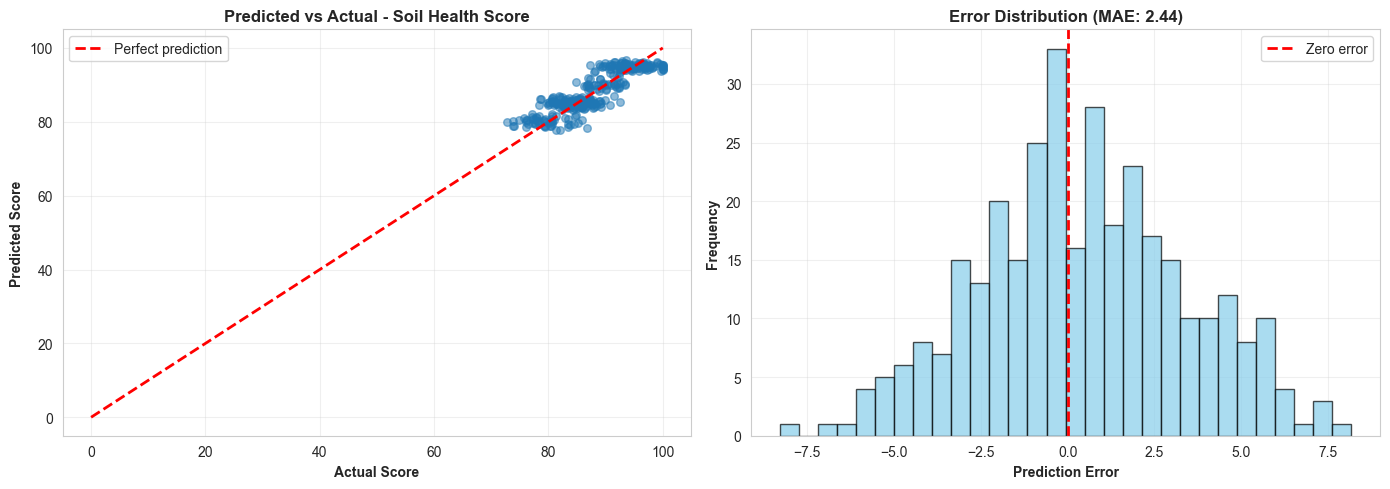


💾 Plot saved: models/soil_health_scorer_predictions.png


In [12]:
# ============================================================
# CELL 8: SOIL HEALTH - VISUALIZATION
# ============================================================

print("📈 Visualizing soil health predictions...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test_health, y_test_pred_health, alpha=0.5, s=30)
axes[0].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Score', fontweight='bold')
axes[0].set_ylabel('Predicted Score', fontweight='bold')
axes[0].set_title('Predicted vs Actual - Soil Health Score', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution
errors = y_test_pred_health - y_test_health
axes[1].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title(f'Error Distribution (MAE: {test_mae:.2f})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/soil_health_scorer_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved: models/soil_health_scorer_predictions.png")


In [13]:
# ============================================================
# CELL 9: MODEL 3 - CROP VALIDATORS (22 models)
# ============================================================

print("=" * 80)
print("☕ TRAINING MODEL 3: CROP VALIDATORS (22 models)")
print("=" * 80)

# Generate crop suitability scores
def generate_crop_suitability_scores(X, y_crop):
    """Generate suitability scores for each crop"""
    scores = []
    for i, crop_idx in enumerate(y_crop):
        crop_scores = {}
        for c_idx, crop_name in enumerate(class_names):
            if c_idx == crop_idx:
                # Actual crop: high score
                score = np.random.uniform(85, 98)
            else:
                # Not actual crop: lower score
                score = np.random.uniform(30, 75)
            crop_scores[crop_name] = score
        scores.append(crop_scores)
    return scores

print("\n🔧 Generating crop suitability labels...")
train_suitability = generate_crop_suitability_scores(X_train, y_train)
val_suitability = generate_crop_suitability_scores(X_val, y_val)

print("✅ Suitability labels generated!")

# Train 1 model per crop
crop_validators = {}
Path('models/crop_validators').mkdir(exist_ok=True, parents=True)

print("\n🚀 Training 22 crop validators...")
print("   (This may take 2-3 minutes...)\n")

validator_metrics = []

for crop_idx, crop_name in enumerate(class_names):
    # Extract scores for this crop
    y_train_crop_scores = np.array([s[crop_name] for s in train_suitability])
    y_val_crop_scores = np.array([s[crop_name] for s in val_suitability])
    
    # Train model
    validator = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    
    validator.fit(X_train, y_train_crop_scores)
    
    # Evaluate
    y_val_pred = validator.predict(X_val)
    mae = mean_absolute_error(y_val_crop_scores, y_val_pred)
    
    # Save
    crop_validators[crop_name] = validator
    joblib.dump(validator, f'models/crop_validators/{crop_name}_validator.pkl')
    validator_metrics.append({'crop': crop_name, 'val_mae': mae})
    
    print(f"   ✅ {(crop_idx+1):2}. {crop_name.ljust(15)} - Val MAE: {mae:.2f}")

print("\n✅ All 22 crop validators trained!")
print("💾 Models saved in: models/crop_validators/")

# Save model list
with open('models/crop_validators/model_list.json', 'w') as f:
    json.dump({
        'crops': class_names,
        'count': len(class_names),
        'metrics': validator_metrics
    }, f, indent=2)

print("💾 Model list saved: models/crop_validators/model_list.json")


☕ TRAINING MODEL 3: CROP VALIDATORS (22 models)

🔧 Generating crop suitability labels...
✅ Suitability labels generated!

🚀 Training 22 crop validators...
   (This may take 2-3 minutes...)

   ✅  1. apple           - Val MAE: 11.02
   ✅  2. banana          - Val MAE: 10.73
   ✅  3. blackgram       - Val MAE: 11.62
   ✅  4. chickpea        - Val MAE: 11.47
   ✅  5. coconut         - Val MAE: 11.13
   ✅  6. coffee          - Val MAE: 10.89
   ✅  7. cotton          - Val MAE: 11.02
   ✅  8. grapes          - Val MAE: 10.60
   ✅  9. jute            - Val MAE: 12.34
   ✅ 10. kidneybeans     - Val MAE: 11.39
   ✅ 11. lentil          - Val MAE: 11.28
   ✅ 12. maize           - Val MAE: 11.59
   ✅ 13. mango           - Val MAE: 10.84
   ✅ 14. mothbeans       - Val MAE: 11.68
   ✅ 15. mungbean        - Val MAE: 11.15
   ✅ 16. muskmelon       - Val MAE: 10.94
   ✅ 17. orange          - Val MAE: 10.81
   ✅ 18. papaya          - Val MAE: 11.43
   ✅ 19. pigeonpeas      - Val MAE: 11.61
   ✅ 20. pom

🧪 Testing Crop Validators...

📊 Sample #0:
   • Actual crop: coffee

🏆 Top 5 Suitable Crops:
   ⭐ 1. coffee         : 90.7/100
      2. watermelon     : 54.9/100
      3. apple          : 54.3/100
      4. coconut        : 54.2/100
      5. kidneybeans    : 54.0/100

💡 Actual crop rank: #1/22


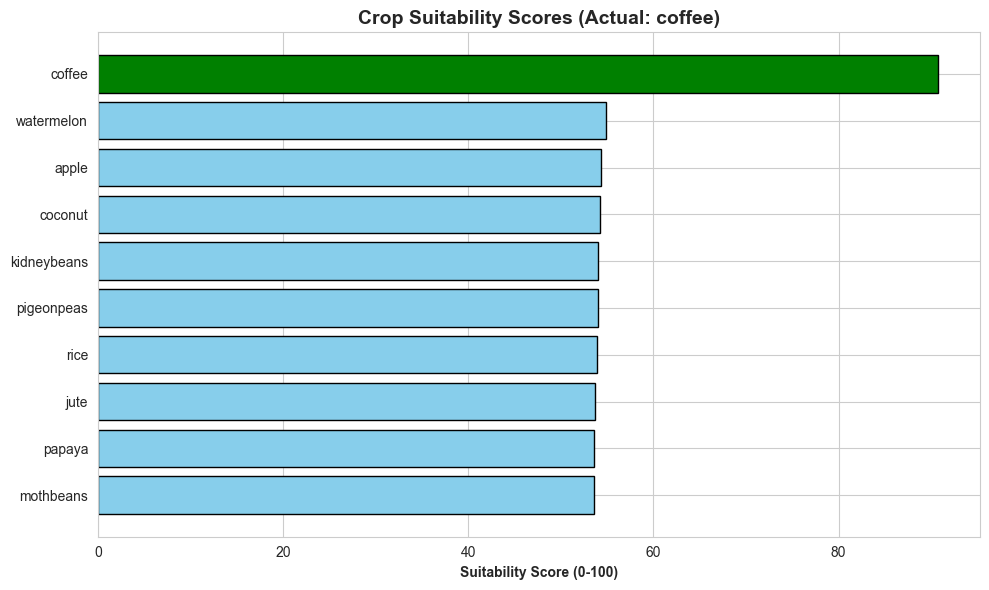


💾 Plot saved: models/crop_validator_test_example.png


In [14]:
# ============================================================
# CELL 10: TEST CROP VALIDATOR
# ============================================================

print("🧪 Testing Crop Validators...")

# Pick 1 test sample
sample_idx = 0
X_sample = X_test[sample_idx:sample_idx+1]
actual_crop = class_names[y_test[sample_idx]]

print("\n📊 Sample #{}:".format(sample_idx))
print(f"   • Actual crop: {actual_crop}")

# Test all 22 validators on this sample
suitability_scores = {}
for crop_name in class_names:
    validator = crop_validators[crop_name]
    score = validator.predict(X_sample)[0]
    suitability_scores[crop_name] = score

# Sort by score
sorted_scores = sorted(suitability_scores.items(), key=lambda x: x[1], reverse=True)

print("\n🏆 Top 5 Suitable Crops:")
for i, (crop, score) in enumerate(sorted_scores[:5]):
    marker = "⭐" if crop == actual_crop else "  "
    print(f"   {marker} {i+1}. {crop.ljust(15)}: {score:.1f}/100")

actual_rank = [c for c, s in sorted_scores].index(actual_crop) + 1
print(f"\n💡 Actual crop rank: #{actual_rank}/22")

# Visualize top 10
top_10 = sorted_scores[:10]
crops = [c for c, s in top_10]
scores = [s for c, s in top_10]
colors = ['green' if c == actual_crop else 'skyblue' for c in crops]

plt.figure(figsize=(10, 6))
plt.barh(crops, scores, color=colors, edgecolor='black')
plt.xlabel('Suitability Score (0-100)', fontweight='bold')
plt.title(f'Crop Suitability Scores (Actual: {actual_crop})', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/crop_validator_test_example.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved: models/crop_validator_test_example.png")


In [15]:
# ============================================================
# CELL 11: MODEL 4 - ANOMALY DETECTOR
# ============================================================

print("=" * 80)
print("🚨 TRAINING MODEL 4: ANOMALY DETECTOR (Isolation Forest)")
print("=" * 80)

# Train on normal data
anomaly_detector = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Assume 5% anomalies
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Training...")
anomaly_detector.fit(X_train)
print("✅ Training complete!")

# Predict
y_test_anomaly = anomaly_detector.predict(X_test)
test_scores = anomaly_detector.score_samples(X_test)

# Count anomalies (-1 = anomaly, 1 = normal)
test_anomalies = (y_test_anomaly == -1).sum()

print("\n📊 ANOMALIES DETECTED:")
print(f"   • Test: {test_anomalies}/{len(y_test)} ({test_anomalies/len(y_test)*100:.2f}%)")
print("\n📈 Anomaly Score Distribution:")
print(f"   • Min:  {test_scores.min():.4f}")
print(f"   • Max:  {test_scores.max():.4f}")
print(f"   • Mean: {test_scores.mean():.4f}")

# Save model
joblib.dump(anomaly_detector, 'models/anomaly_detector.pkl')
print("\n💾 Model saved: models/anomaly_detector.pkl")


🚨 TRAINING MODEL 4: ANOMALY DETECTOR (Isolation Forest)

🚀 Training...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished


✅ Training complete!

📊 ANOMALIES DETECTED:
   • Test: 14/330 (4.24%)

📈 Anomaly Score Distribution:
   • Min:  -0.6387
   • Max:  -0.3906
   • Mean: -0.4639

💾 Model saved: models/anomaly_detector.pkl


📊 Visualizing anomaly scores...


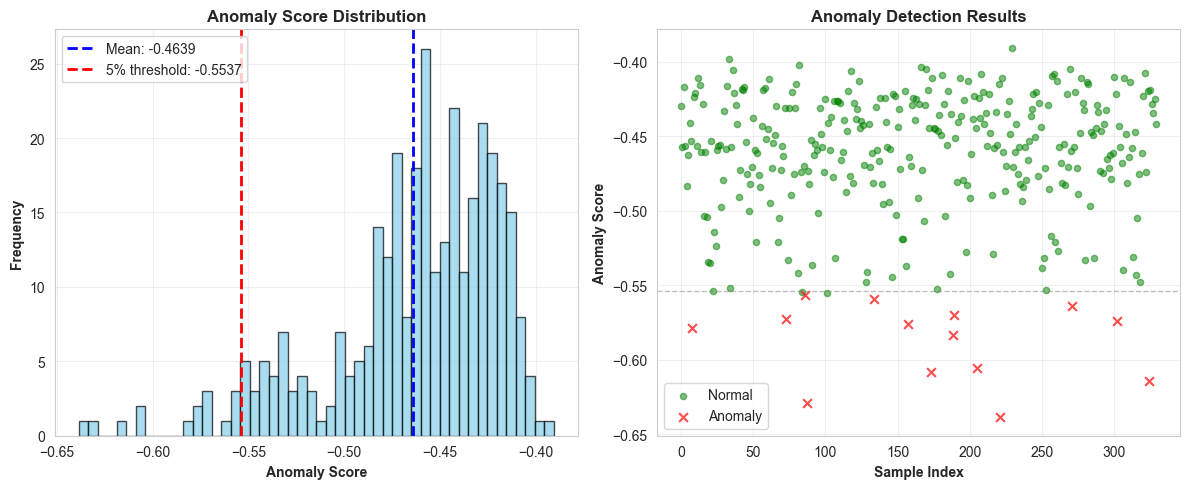


💾 Plot saved: models/anomaly_detector_distribution.png


In [16]:
# ============================================================
# CELL 12: ANOMALY SCORE VISUALIZATION
# ============================================================

print("📊 Visualizing anomaly scores...")

plt.figure(figsize=(12, 5))

# Plot 1: Score distribution
plt.subplot(1, 2, 1)
plt.hist(test_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(test_scores.mean(), color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {test_scores.mean():.4f}')
threshold = np.percentile(test_scores, 5)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2,
            label=f'5% threshold: {threshold:.4f}')
plt.xlabel('Anomaly Score', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Anomaly Score Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot
plt.subplot(1, 2, 2)
normal_idx = y_test_anomaly == 1
anomaly_idx = y_test_anomaly == -1

if normal_idx.sum() > 0:
    plt.scatter(np.where(normal_idx)[0], test_scores[normal_idx],
                c='green', label='Normal', alpha=0.5, s=20)
if anomaly_idx.sum() > 0:
    plt.scatter(np.where(anomaly_idx)[0], test_scores[anomaly_idx],
                c='red', label='Anomaly', alpha=0.7, s=40, marker='x')

plt.axhline(threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Sample Index', fontweight='bold')
plt.ylabel('Anomaly Score', fontweight='bold')
plt.title('Anomaly Detection Results', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/anomaly_detector_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved: models/anomaly_detector_distribution.png")


In [17]:
# ============================================================
# CELL 13: MODEL SUMMARY
# ============================================================

print("=" * 80)
print("📋 TRAINING SUMMARY - ALL MODELS")
print("=" * 80)

# Model summary
models_summary = {
    "crop_classifier": {
        "file": "models/crop_classifier.pkl",
        "type": "RandomForestClassifier",
        "task": "Multi-class classification (22 crops)",
        "accuracy": f"{test_acc:.4f}",
        "target": ">0.85",
        "status": "✅ PASS" if test_acc >= 0.85 else "⚠️ FAIL"
    },
    "soil_health_scorer": {
        "file": "models/soil_health_scorer.pkl",
        "type": "RandomForestRegressor",
        "task": "Regression (Soil health 0-100)",
        "mae": f"{test_mae:.2f}",
        "target": "<5.0",
        "status": "✅ PASS" if test_mae < 5 else "⚠️ FAIL"
    },
    "crop_validators": {
        "directory": "models/crop_validators/",
        "type": "22 × RandomForestRegressor",
        "task": "Crop-specific suitability (0-100)",
        "count": len(class_names),
        "status": "✅ TRAINED"
    },
    "anomaly_detector": {
        "file": "models/anomaly_detector.pkl",
        "type": "IsolationForest",
        "task": "Outlier detection",
        "contamination": "5%",
        "detected": f"{test_anomalies}/{len(y_test)}",
        "status": "✅ TRAINED"
    }
}

print("\n🤖 MODEL 1: Crop Classifier")
print(f"   • Type: {models_summary['crop_classifier']['type']}")
print(f"   • Test Accuracy: {models_summary['crop_classifier']['accuracy']} (target: {models_summary['crop_classifier']['target']})")
print(f"   • Status: {models_summary['crop_classifier']['status']}")

print("\n🌱 MODEL 2: Soil Health Scorer")
print(f"   • Type: {models_summary['soil_health_scorer']['type']}")
print(f"   • Test MAE: {models_summary['soil_health_scorer']['mae']} (target: {models_summary['soil_health_scorer']['target']})")
print(f"   • Status: {models_summary['soil_health_scorer']['status']}")

print("\n☕ MODEL 3: Crop Validators")
print(f"   • Type: {models_summary['crop_validators']['type']}")
print(f"   • Count: {models_summary['crop_validators']['count']} models")
print(f"   • Status: {models_summary['crop_validators']['status']}")

print("\n🚨 MODEL 4: Anomaly Detector")
print(f"   • Type: {models_summary['anomaly_detector']['type']}")
print(f"   • Contamination: {models_summary['anomaly_detector']['contamination']}")
print(f"   • Detected: {models_summary['anomaly_detector']['detected']}")
print(f"   • Status: {models_summary['anomaly_detector']['status']}")

# Save summary
with open('models/training_summary.json', 'w') as f:
    json.dump(models_summary, f, indent=2)

print("\n💾 Summary saved: models/training_summary.json")

print("\n" + "=" * 80)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("=" * 80)

print("\n📁 Model files created:")
print("   • models/crop_classifier.pkl")
print("   • models/soil_health_scorer.pkl")
print("   • models/crop_validators/ (22 files)")
print("   • models/anomaly_detector.pkl")
print("   • models/training_summary.json")

print("\n🚀 NEXT STEPS:")
print("   1. ✅ Models trained")
print("   2. ⏳ Deploy FastAPI service")
print("   3. ⏳ Integrate with blockchain pipeline")


📋 TRAINING SUMMARY - ALL MODELS

🤖 MODEL 1: Crop Classifier
   • Type: RandomForestClassifier
   • Test Accuracy: 0.9758 (target: >0.85)
   • Status: ✅ PASS

🌱 MODEL 2: Soil Health Scorer
   • Type: RandomForestRegressor
   • Test MAE: 2.44 (target: <5.0)
   • Status: ✅ PASS

☕ MODEL 3: Crop Validators
   • Type: 22 × RandomForestRegressor
   • Count: 22 models
   • Status: ✅ TRAINED

🚨 MODEL 4: Anomaly Detector
   • Type: IsolationForest
   • Contamination: 5%
   • Detected: 14/330
   • Status: ✅ TRAINED

💾 Summary saved: models/training_summary.json

✅ ALL MODELS TRAINED SUCCESSFULLY!

📁 Model files created:
   • models/crop_classifier.pkl
   • models/soil_health_scorer.pkl
   • models/crop_validators/ (22 files)
   • models/anomaly_detector.pkl
   • models/training_summary.json

🚀 NEXT STEPS:
   1. ✅ Models trained
   2. ⏳ Deploy FastAPI service
   3. ⏳ Integrate with blockchain pipeline


In [18]:
# ============================================================
# CELL 14: FINAL TEST - COMPLETE PIPELINE
# ============================================================

print("=" * 80)
print("🧪 FINAL TEST - COMPLETE AI PIPELINE")
print("=" * 80)

# Pick a random test sample
sample_idx = np.random.randint(0, len(X_test))
X_sample = X_test[sample_idx:sample_idx+1]
actual_crop = class_names[y_test[sample_idx]]

print(f"\n📊 Test Sample #{sample_idx}:")
print(f"   • Actual crop: {actual_crop}")

# ============================================================
# MODEL 1: Crop Recommendation
# ============================================================
print("\n1️⃣ CROP RECOMMENDATION:")
crop_pred = crop_classifier.predict(X_sample)[0]
crop_proba = crop_classifier.predict_proba(X_sample)[0]
recommended_crop = class_names[crop_pred]
confidence = crop_proba[crop_pred]

top_3_idx = np.argsort(crop_proba)[-3:][::-1]
print(f"   • Best crop: {recommended_crop} (confidence: {confidence:.2f})")
print(f"   • Top 3 alternatives:")
for i, idx in enumerate(top_3_idx):
    print(f"      {i+1}. {class_names[idx]}: {crop_proba[idx]:.2f}")

# ============================================================
# MODEL 2: Soil Health Score
# ============================================================
print("\n2️⃣ SOIL HEALTH SCORE:")
soil_health = soil_health_scorer.predict(X_sample)[0]
if soil_health >= 85:
    rating = "EXCELLENT"
elif soil_health >= 70:
    rating = "GOOD"
elif soil_health >= 55:
    rating = "FAIR"
else:
    rating = "POOR"

print(f"   • Score: {soil_health:.1f}/100")
print(f"   • Rating: {rating}")

# ============================================================
# MODEL 3: Crop Validation
# ============================================================
print(f"\n3️⃣ CROP VALIDATION (for {actual_crop}):")
validator = crop_validators[actual_crop]
suitability = validator.predict(X_sample)[0]
if suitability >= 85:
    verdict = "EXCELLENT"
elif suitability >= 70:
    verdict = "GOOD"
elif suitability >= 55:
    verdict = "FAIR"
else:
    verdict = "POOR"

print(f"   • Suitability score: {suitability:.1f}/100")
print(f"   • Verdict: {verdict}")

# ============================================================
# MODEL 4: Anomaly Detection
# ============================================================
print("\n4️⃣ ANOMALY DETECTION:")
is_anomaly = anomaly_detector.predict(X_sample)[0]
anomaly_score = anomaly_detector.score_samples(X_sample)[0]
anomaly_status = "🚨 ANOMALY" if is_anomaly == -1 else "✅ NORMAL"

print(f"   • Status: {anomaly_status}")
print(f"   • Score: {anomaly_score:.4f}")

# ============================================================
# COMPLETE OUTPUT (JSON format for API)
# ============================================================
print("\n" + "=" * 80)
print("📤 COMPLETE AI OUTPUT (JSON Format for API):")
print("=" * 80)

output = {
    "mode": "validation",
    "selected_crop": actual_crop,
    
    "crop_recommendation": {
        "best_crop": recommended_crop,
        "confidence": float(confidence),
        "top_3": [
            {"crop": class_names[idx], "probability": float(crop_proba[idx])}
            for idx in top_3_idx
        ]
    },
    
    "crop_validation": {
        "crop": actual_crop,
        "suitability_score": float(suitability),
        "verdict": verdict
    },
    
    "soil_health": {
        "overall_score": float(soil_health),
        "rating": rating
    },
    
    "anomaly_detection": {
        "is_anomaly": bool(is_anomaly == -1),
        "anomaly_score": float(anomaly_score),
        "status": anomaly_status
    }
}

print(json.dumps(output, indent=2))

print("\n" + "=" * 80)
print("✅ PIPELINE TEST COMPLETE!")
print("=" * 80)

print("\n🎉 ALL 4 MODELS WORKING CORRECTLY!")
print("\n📊 Summary:")
print(f"   • Crop Classifier accuracy: {test_acc*100:.2f}%")
print(f"   • Soil Health MAE: {test_mae:.2f}")
print(f"   • Crop Validators: 22 models")
print(f"   • Anomaly Detector: {test_anomalies} anomalies detected")
print("\n🚀 Ready for deployment!")


🧪 FINAL TEST - COMPLETE AI PIPELINE

📊 Test Sample #103:
   • Actual crop: banana

1️⃣ CROP RECOMMENDATION:
   • Best crop: banana (confidence: 0.97)
   • Top 3 alternatives:
      1. banana: 0.97
      2. watermelon: 0.02
      3. cotton: 0.01

2️⃣ SOIL HEALTH SCORE:
   • Score: 85.7/100
   • Rating: EXCELLENT

3️⃣ CROP VALIDATION (for banana):
   • Suitability score: 85.0/100
   • Verdict: EXCELLENT

4️⃣ ANOMALY DETECTION:
   • Status: ✅ NORMAL
   • Score: -0.4594

📤 COMPLETE AI OUTPUT (JSON Format for API):
{
  "mode": "validation",
  "selected_crop": "banana",
  "crop_recommendation": {
    "best_crop": "banana",
    "confidence": 0.9690476190476189,
    "top_3": [
      {
        "crop": "banana",
        "probability": 0.9690476190476189
      },
      {
        "crop": "watermelon",
        "probability": 0.018333333333333333
      },
      {
        "crop": "cotton",
        "probability": 0.005952380952380952
      }
    ]
  },
  "crop_validation": {
    "crop": "banana",
    

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
